In [3]:
from __future__ import absolute_import, division, print_function

import sys
import operator
import numpy as np
import pandas as pd
import tensorflow as tf
import csv
from tensorflow import keras
from sklearn.model_selection import StratifiedKFold
# tf.enable_eager_execution()

data_x = None
data_y = None

tf.enable_eager_execution()
inputFile = './data/GritMindset.csv'

In [26]:
def getData():
    global data_x
    global data_y
    data_x = pd.read_csv(inputFile)
    label = 'HonorsScience'
    lblTypes = set(data_x[label])
    lblTypes = dict(zip(lblTypes, [0] * 2))
    lblTypes[2] = 1
    data_x[label] = data_x[label].map(lblTypes)
    data_x = data_x.sample(frac=1).reset_index(drop=True)
    data_y = data_x.pop(label)

In [27]:
getData()

In [28]:
data_x.head()

,Gender,Age,HighSchoolGrade
0,2,19,94.0
1,1,18,85.0
2,2,17,70.0
3,1,20,80.0
4,1,25,80.0


In [29]:
data_x.describe()

,Gender,Age,HighSchoolGrade
count,309.000000,309.000000,309.000000
mean,1.582524,21.792880,81.741489
std,0.531921,7.750313,13.316868
min,1.000000,3.000000,0.000000
25%,1.000000,18.000000,80.000000
50%,2.000000,19.000000,85.000000
75%,2.000000,22.000000,88.000000
max,3.000000,99.000000,99.000000


In [30]:
data_x.shape

(309, 3)

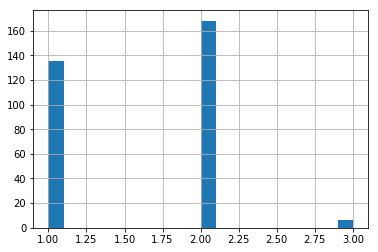

In [31]:
data_x.Gender.hist(bins=20)

In [32]:
fc = tf.feature_column
CATEGORICAL_COLUMNS = []
NUMERIC_COLUMNS = ['Gender', 'Age', 'HighSchoolGrade']
  
def one_hot_cat_column(feature_name, vocab):
  return fc.indicator_column(
      fc.categorical_column_with_vocabulary_list(feature_name,
                                                 vocab))
feature_columns = []
for feature_name in CATEGORICAL_COLUMNS:
  # Need to one-hot encode categorical features.
  vocabulary = dftrain[feature_name].unique()
  feature_columns.append(one_hot_cat_column(feature_name, vocabulary))
  
for feature_name in NUMERIC_COLUMNS:
  feature_columns.append(fc.numeric_column(feature_name,
                                           dtype=tf.float32))

In [33]:
fc.input_layer(dict(data_x.head(1)), feature_columns).numpy()

array([[19.,  2., 94.]], dtype=float32)

In [34]:
trainSamples = int(0.8*len(data_x))
dftrain, y_train = data_x[:trainSamples], data_y[:trainSamples]
dfeval, y_eval = data_x[trainSamples:], data_y[trainSamples:]

In [35]:
# Use entire batch since this is such a small dataset.
NUM_EXAMPLES = len(y_train)

def make_input_fn(X, y, n_epochs=None, shuffle=True):
  def input_fn():
    dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
    if shuffle:
      dataset = dataset.shuffle(NUM_EXAMPLES)
    # For training, cycle thru dataset as many times as need (n_epochs=None).    
    dataset = dataset.repeat(n_epochs)  
    # In memory training doesn't use batching.
    dataset = dataset.batch(NUM_EXAMPLES)
    return dataset
  return input_fn

# Training and evaluation input functions.
train_input_fn = make_input_fn(dftrain, y_train)
eval_input_fn = make_input_fn(dfeval, y_eval, shuffle=False, n_epochs=1)

In [36]:
linear_est = tf.estimator.LinearClassifier(feature_columns)

# Train model.
linear_est.train(train_input_fn, max_steps=100)

# Evaluation.
results = linear_est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

W0916 22:18:43.921094 140736667390912 estimator.py:1799] Using temporary folder as model directory: /var/folders/4f/1pkkv7h960j42p0ppgk9n4ywjr6t_b/T/tmpn17dt32g
W0916 22:18:46.591497 140736667390912 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.
W0916 22:18:46.621157 140736667390912 metrics_impl.py:804] Trapezoidal rule is known to produce incorrect PR-AUCs; please switch to "careful_interpolation" instead.


Accuracy :  0.88709676
Dummy model:  0.9032258


In [37]:
# Since data fits into memory, use entire dataset per layer. It will be faster.
# Above one batch is defined as the entire dataset. 
n_batches = 1
est = tf.estimator.BoostedTreesClassifier(feature_columns,
                                          n_batches_per_layer=n_batches)

# The model will stop training once the specified number of trees is built, not 
# based on the number of steps.
est.train(train_input_fn, max_steps=100)

# Eval.
results = est.evaluate(eval_input_fn)
print('Accuracy : ', results['accuracy'])
print('Dummy model: ', results['accuracy_baseline'])

W0916 22:19:10.342537 140736667390912 estimator.py:1799] Using temporary folder as model directory: /var/folders/4f/1pkkv7h960j42p0ppgk9n4ywjr6t_b/T/tmpcsgr46_2
W0916 22:19:10.662702 140736667390912 meta_graph.py:448] Issue encountered when serializing resources.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
W0916 22:19:11.196376 140736667390912 meta_graph.py:448] Issue encountered when serializing resources.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has no attribute 'name'
W0916 22:19:11.300307 140736667390912 meta_graph.py:448] Issue encountered when serializing resources.
Type is unsupported, or the types of the items don't match field type in CollectionDef. Note this is a warning and probably safe to ignore.
'_Resource' object has n

Accuracy :  0.9032258
Dummy model:  0.9032258


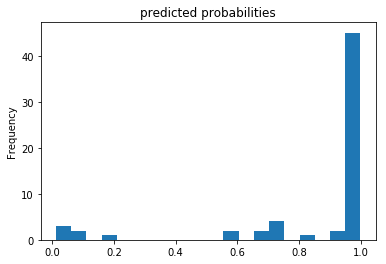

In [38]:
pred_dicts = list(est.predict(eval_input_fn))
probs = pd.Series([pred['probabilities'][1] for pred in pred_dicts])

probs.plot(kind='hist', bins=20, title='predicted probabilities');

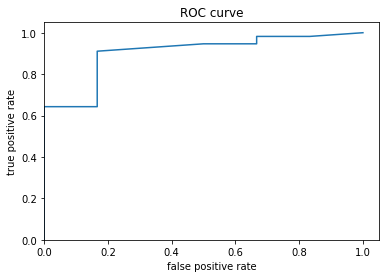

In [39]:
from sklearn.metrics import roc_curve
from matplotlib import pyplot as plt

fpr, tpr, _ = roc_curve(y_eval, probs)
plt.plot(fpr, tpr)
plt.title('ROC curve')
plt.xlabel('false positive rate')
plt.ylabel('true positive rate')
plt.xlim(0,)
plt.ylim(0,);